In [1]:
import os
# from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib
from matplotlib.colors import BoundaryNorm, LogNorm
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, AutoMinorLocator
from matplotlib.ticker import MaxNLocator
import pandas as pd
import datetime
from mpl_toolkits.mplot3d import Axes3D, axes3d

# import pandas as pd
import xarray as xr
from scipy import signal, integrate
from waveletFunctions import wave_signif, wavelet

from palettable.mycarta import Cube1_10

import subroutines
import vis_eulag

plt.style.use('latex_default.mplstyle')

In [2]:
SETTINGS = vis_eulag.load_settings('settings_local_translb.txt')
fileLocations = ['/work/bd0620/b309199/translb3D/translb3D_001', '/work/bd0620/b309199/translb3D/translb3D_002']
labels=['N-S TD', 'NW-SE TD']

ds_list = []
for fileLocation in fileLocations:
    env_fileName = "env.nc"
    tapes_fileName = "tapes.nc" # "tapes.nc"
    grid_fileName = "grd.nc"
    env_path = os.path.join(fileLocation, env_fileName)
    tapes_path = os.path.join(fileLocation, tapes_fileName)
    grid_path = os.path.join(fileLocation, grid_fileName)

    ds = xr.open_dataset(tapes_path) #, decode_times=False)
    # DS['alt_plot'] = (DS.altitude + DS.altitude_offset + DS.station_height) / 1000 #km
    # DS.temperature.values = np.where(DS.temperature == 0, np.nan, DS.temperature) # Change 0 to NaN

    ds_grid = xr.open_dataset(grid_path)
    ds_env = xr.open_dataset(env_path)

    if len(ds.w.shape) == 3: # 2D case
        # ds_env['time'] = ds['time']
        ds = ds.drop('time')
        ds['ELEVATION'] = ds['ELEVATION'].expand_dims({'t':ds.t})
        # ds = ds.drop('ELEVATION')
        ds = ds.expand_dims('y',axis=2)

    if len(ds_env.ue.shape) == 3: # not time depedant case
        ds_env = ds_env.expand_dims({'t':ds.t})

    ds = ds.assign_coords({'xcr':ds_grid['xcr']/1000, 'zcr':ds_env['zcr']/1000, 'ycr':ds_grid['ycr']/1000,
                          'zs':ds_grid['zs']/1000, 'zh':ds_grid['zh']/1000, 'gi':ds_grid['gi']})
    ds_env = ds_env.drop('zcr')
    ds = ds.merge(ds_env)

    # ---- Sim parameters -------------- # 
    ds.attrs = ds_grid.attrs
    ds.attrs['bv'] = ds.attrs['bv'].round(3)
    ds.attrs['u00'] = ds['ue'][0,0,0,0].values
    ds.attrs['v00'] = ds['ve'][0,0,0,0].values
    ds.attrs['nx'] = np.shape(ds['w'])[3]
    ds.attrs['ny'] = np.shape(ds['w'])[2]
    ds.attrs['nz'] = np.shape(ds['w'])[1]
    
    ds = subroutines.dzdx_topo(ds)
    # ---- Sim parameters -------------- # 

    # ---- Constants ------------------- #
    pref00=101325.
    # pref00=23700.
    ds.attrs['cp']=3.5*ds.rg # Earth
    ds.attrs['grav']=ds.g
    ds.attrs['cap']=ds.rg/ds.cp
    ds.attrs['capi'] =1/ds.cap
    ds.attrs['capp']=1-ds.cap # Cv/Cp
    ds.attrs['cappi']=1/ds.capp   # Cp/Cv
    ds.attrs['compri']=ds.rg/pref00**ds.cap
    # ---- Constants ------------------- # 

    # ---- IDL code of AD -------------- # 
    # Forces (MF_x, EF_z, EF_x)
    # h1: ttt (theta)
    # h2: tloc-tte with tloc = thloc*(ploc/pref00)^cap
    # h3: wprime = w
    # h4: tprime+the
    # h5: sqrt(uprime^2+vprime^2)
    # h6: uprime
    # h7: ploc or h12-h12(100), h12=p
    # h9: MFx
    # h11: EFx
    # h12: pprime filtered
    # ---- IDL code of AD -------------- #

    # ---- Perturbations -- #
    # Uncomment line that suits available data
    # ds['uprime'] = ds['u'] - ds['u'][:,:,:,0] # time-dependant background state
    # ds['uprime'] = ds['u'] - ds['ue']

    # ds['vprime'] = ds['v'] - ds['ve'][:,:,:,0] # time-dependant background state
    # ds['vprime'] = ds['v'] - ds['ve']

    # ds['wprime'] = ds['w']
    
    # ---- Pressure ------- #
    ds['pref00'] = ds['pr0'].max() # Pa pref00=101325.
    # p is pressure perturbation output from EULAG
    # h12 is 2D filtered
    # h7 additionally referenced to x-location before mtn
    # ppe=(rhe*the*compri)^cappi
    ds['pprime']=ds['p'] # h12
    # ds['pprime']=filt_2dx(ds['p'],1) # h12
    # ds['pprime']=filt_2dx(ds['p'],0) # h12
    # ds['ploc'] = ds['pprime'] + ds['pr0']
    # ds['h7'] = ds['pprime'] - ds['pprime'][:,:,:,100] # x=100 before mtn?

    ds_cp = ds.copy()
    ds_list.append(ds_cp)

In [3]:
ds

<xarray.Dataset>
Dimensions:    (t: 7, z: 251, y: 480, x: 720)
Coordinates:
    xcr        (y, x) float32 0.0 20.0 40.0 ... 1.434e+04 1.436e+04 1.438e+04
    zcr        (t, z, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 75.0 75.0 75.0 75.0
    ycr        (y, x) float32 -4.79e+03 -4.79e+03 ... 4.79e+03 4.79e+03
    zs         (y, x) float32 -0.0 -0.0 -0.0 -0.0 -0.0 ... -0.0 -0.0 -0.0 -0.0
    zh         (y, x) float32 75.0 75.0 75.0 75.0 75.0 ... 75.0 75.0 75.0 75.0
    gi         (y, x) float32 ...
Dimensions without coordinates: t, z, y, x
Data variables: (12/20)
    time       (t) float32 ...
    u          (t, z, y, x) float32 ...
    v          (t, z, y, x) float32 ...
    w          (t, z, y, x) float32 ...
    th         (t, z, y, x) float32 ...
    p          (t, z, y, x) float32 ...
    ...         ...
    rh0        (t, z, y, x) float32 ...
    pr0        (t, z, y, x) float32 2.838e+04 2.838e+04 ... 0.6307 0.6307
    ppe        (t, z, y, x) float32 ...
    dzdx_surf  (y, x) float32 -0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 -0.0
    pref00     float64 3.158e+04
    pprime     (t, z, y, x) float32 ...
Attributes: (12/54)
    nt:           4320
    nplot:        720
    nstore:       100000
    nlid:         5
    dt00:         60.0
    dx00:         20000.0
    ...           ...
    grav:         9.80616
    cap:          0.2857142857142857
    capi:         3.5
    capp:         0.7142857142857143
    cappi:        1.4
    compri:       10.659520642663725

-0.00011946513413910657
-0.00011946513413910657


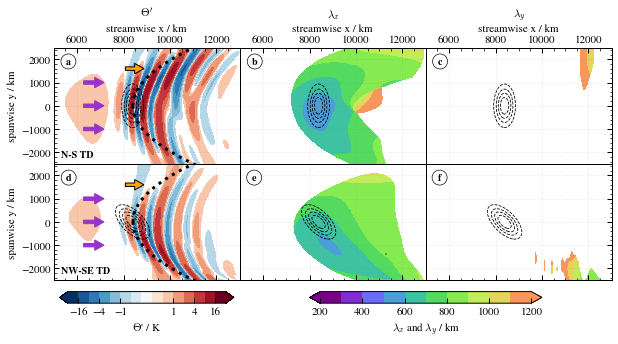

In [4]:
# --- Wavelet analysis (2D zonal wavelength) --- #
# fig, ((ax0,ax1),(ax2,ax3)) = plt.subplots(2,2,figsize=(12,9),sharey=True)
# plt.grid(b=True, color='grey', alpha=0.2, linestyle=':', linewidth=2)
# gskw = {'left':0,'bottom':0,'right':1,'top':1,'wspace':0,'hspace':0,'height_ratios': [10,10,10,10,10,2]}
gskw = {'wspace':0,'hspace':0,'height_ratios': [10,10,2]}
fig, axes = plt.subplots(3,3,figsize=(10,4.7),sharex=True,sharey=True,gridspec_kw=gskw)
axes[0,0].xaxis.set_minor_locator(AutoMinorLocator())
axes[0,0].yaxis.set_minor_locator(AutoMinorLocator())

# - Colormaps - # 
cmap = Cube1_10.mpl_colormap
# clev = [250,300,350,400,450,500,550,600,700,800,900,1000,1100,1200]
clev = [200,300,400,500,600,700,800,900,1000,1100,1200]
# clev = [6,8,10,12,14,16,18,20,25,35,55]
norm = BoundaryNorm(boundaries=clev,ncolors=cmap.N,clip=True)

cmap_th = plt.get_cmap('RdBu_r')
clev_th, clev_l_th = subroutines.get_colormap_bins_and_labels(max_level=32)
norm_th = BoundaryNorm(boundaries=clev_th, ncolors=cmap_th.N, clip=True)

# - Parameters for plots - #
t=6
z=133 # 40km (dz=300m)
# z=100 # 30km
z_l = 40 # km
nx_avg = int(600*1000/ds.dx00) # lambda filter = 600km

mother = 'MORLET'
lag1 = 0.72  # lag-1 autocorrelation for red noise background
sig_lev = 1


calc_lambdaz = True
mfx_option='obs'
mfx_o = []
mfx_s = []
mfy_o = []
mfy_s = []

numbers = ['a','b','c','d','e','f','g','i','j','k','l','m','n','o','p','q','r','s']
j = 0
for ds in ds_list:
    # ---- Calculations ---- #
    if j==0:
        y_jet = 0 # km
    else:
        y_jet = -1500 # km
                         
    data=ds['th'][t,z,:,:].values
    variance = np.std(data, ddof=1) ** 2
    
    
    # - Coriolis and dthdz for angular momentum flux calculation - #
    f = ds.fcr0 * np.sin(ds.ang*np.pi/180)
    print(f)
    
    z_coord = np.linspace(0,ds.zcr[0,-1,0,0],ds.nz)*1000
    the = ds['the'][t,:,:,:]
    the = the.assign_coords(z_coord = ("z",z_coord))
    dthdz = the.differentiate("z_coord")
    
    # -- lambda x -- #
    lambdax = np.zeros(np.shape(data))
    n = ds.nx
    dx = ds.dx00/1000 # km
    # pad = 1  # pad the time series with zeroes (recommended)
    dj = 0.0625  # this will do 4 sub-octaves per octave
    s0 = 2 * dx  # this says start at a scale of 6 months
    j1 = 5 / dj  # this says do 7 powers-of-two with dj sub-octaves each

    for y in range(0,ds.ny):
        wave, period, scale, coi = wavelet(data[y,:], dx, dj=dj, s0=s0, J1=j1, mother=mother)
        power = (np.abs(wave)) ** 2  # / variance # wavelet power spectrum normalized by variance

        # - Significance levels - #
        signif = wave_signif(([variance]), dt=dx, sigtest=0, scale=scale, lag1=lag1, mother=mother)
        # expand signif --> (J+1)x(N) array
        sig95 = signif[:, np.newaxis].dot(np.ones(n)[np.newaxis, :])
        sig95 = power / sig95  # where ratio > 1, power is significant

        # jvec holds indices of maximum power for each x-location
        # indices refer to certain wavelengths
        jvec = np.argmax(power,axis=0)
        xvec = np.arange(0,len(jvec),1)
        lambdax[y,:] = np.where(sig95[jvec,xvec] > sig_lev, period[jvec], np.nan)
        # lambdax[y,:] = np.where(power[jvec,xvec] > E_THRESHOLD, period[jvec], np.nan) # E_THRESHOLD = 25

    # -- lambda y -- #
    lambday = np.zeros(np.shape(data))
    n = ds.ny
    dy = ds.dy00/1000 # km
    # pad = 1  # pad the time series with zeroes (recommended)
    dj = 0.0625  # this will do 4 sub-octaves per octave
    s0 = 2 * dy  # this says start at a scale of 6 months
    j1 = 7 / dj  # this says do 7 powers-of-two with dj sub-octaves each

    for x in range(0,ds.nx):
        wave, period, scale, coi = wavelet(data[:,x], dy, dj=dj, s0=s0, J1=j1, mother=mother)
        power = (np.abs(wave)) ** 2 # / variance # wavelet power spectrum normalized by variance

        # - Significance levels - #
        signif = wave_signif(([variance]), dt=dy, sigtest=0, scale=scale, lag1=lag1, mother=mother)
        # expand signif --> (J+1)x(N) array
        sig95 = signif[:, np.newaxis].dot(np.ones(n)[np.newaxis, :])
        sig95 = power / sig95  # where ratio > 1, power is significant

        # jvec holds indices of maximum power for each x-location
        # indices refer to certain wavelengths
        jvec = np.argmax(power,axis=0)
        yvec = np.arange(0,len(jvec),1)
        lambday[:,x] = np.where(sig95[jvec,yvec] > sig_lev, period[jvec], np.nan)
    
    # - Filter wavelengths - #
    lambdax = np.where(lambdax<1200,lambdax,np.nan)
    lambday = np.where(lambday<1200,lambday,np.nan)
    
    # -- lambda z -- #
    if calc_lambdaz:
        data3D=ds['th'][t,:,:,:].values
        # variance = np.std(data3D, ddof=1) ** 2
        lambdaz = np.zeros(np.shape(data))

        n = ds.nz
        dz = ds.dz00/1000 # km
        # pad = 1  # pad the time series with zeroes (recommended)
        dj = 0.25  # this will do 4 sub-octaves per octave
        # s0 = 8 * dz  # this says start at a scale of 6 months
        # j1 = 4 / dj  # this says do 7 powers-of-two with dj sub-octaves each
        s0 = 2 * dz  # this says start at a scale of 6 months
        j1 = 7 / dj  # this says do 7 powers-of-two with dj sub-octaves each

        for x in range(0,ds.nx):
            for y in range(0,ds.ny):
                if (np.isnan(lambdax[y,x])==False) and (np.isnan(lambday[y,x])==False):
                    wave, period, scale, coi = wavelet(data3D[:,y,x], dz, dj=dj, s0=s0, J1=j1, mother=mother)
                    power = (np.abs(wave)) ** 2 # / variance # wavelet power spectrum normalized by variance
                    
                    # - Significance levels - #
                    signif= wave_signif(([variance]), dt=dz, sigtest=0, scale=scale, lag1=lag1, mother=mother)
                    sig95 = signif[:, np.newaxis].dot(np.ones(n)[np.newaxis, :])
                    sig95 = power / sig95  # where ratio > 1, power is significant
                    
                    jmax = np.argmax(power[:,z])
                    lambdaz[y,x] = np.where(sig95[jmax,z] > sig_lev, period[jmax], np.nan)
                    lambdaz[y,x] = period[jmax]
                else:
                    lambdaz[y,x] = np.nan
    else:
        lambdaz=12
    
    # - Filter wavelengths - #
    lambdaz = np.where(lambdaz<30,lambdaz,np.nan)
    
    # - Ep - #
    thloc = ds['the'][t,z,:,:] + ds['th'][t,z,:,:] # Theta
    # ds['tloc'] = ds['thloc']*(ds['ploc']/ds['pref00'])**ds.cap
    tte = ds['the'][t,z,:,:]*(ds['pr0'][t,z,:,:]/ds['pref00'])**ds.cap # T_env
    tloc = thloc*(ds['pr0'][t,z,:,:]/ds['pref00'])**ds.cap # T
    tprime = tloc-tte
    
    # ep = 1/2*(ds.grav/ds.bv)**2 * (tprime/tte)**2 # * ds['rh0'].expand_dims({'t':ds.t}) potential energy density
    ep = 1/2*ds['rh0'][t,z,:,:]*(ds.grav/ds.bv)**2 * (ds['th'][t,z,:,:]/ds['the'][t,z,:,:])**2
    # ep=subroutines.fft_gaussian_xy(ep,nx_avg,ny_avg=None)
    
    # - MFx and MFy - #
    mfx_obs = ep * lambdaz/(-lambdax)
    mfy_obs = ep * lambdaz/(-lambday)
    mfx_obs = subroutines.fft_gaussian_xy(mfx_obs,nx_avg,ny_avg=None)
    mfy_obs = subroutines.fft_gaussian_xy(mfy_obs,nx_avg,ny_avg=None)
    
    mfx_sim = ds['rh0'][t,z,:,:] * ds['w'][t,z,:,:] * (ds['u'][t,z,:,:]-ds['ue'][t,z,:,:]) 
    mfy_sim = ds['rh0'][t,z,:,:] * ds['w'][t,z,:,:] * (ds['v'][t,z,:,:]-ds['ve'][t,z,:,:])
    # mfx_sim = ds['rh0'][t,z,:,:] * (ds['w'][t,z,:,:] * (ds['u'][t,z,:,:]-ds['ue'][t,z,:,:]) - f * (ds['v'][t,z,:,:]-ds['ve'][t,z,:,:]) * ds['th'][t,z,:,:] / dthdz[z,:,:]) 
    # mfy_sim = ds['rh0'][t,z,:,:] * (ds['w'][t,z,:,:] * (ds['v'][t,z,:,:]-ds['ve'][t,z,:,:]) + f * (ds['u'][t,z,:,:]-ds['ue'][t,z,:,:]) * ds['th'][t,z,:,:] / dthdz[z,:,:])
    mfx_sim = subroutines.fft_gaussian_xy(mfx_sim,nx_avg,ny_avg=None)
    mfy_sim = subroutines.fft_gaussian_xy(mfy_sim,nx_avg,ny_avg=None)
    
    if mfx_option=='obs':
        mfx=mfx_obs
        mfy=mfy_obs
    else:
        mfx=mfx_sim
        mfy=mfy_sim
    
    # - Save list of arrays for scatter plot - #
    mfx_o.append(mfx_obs.values.flatten())
    mfx_s.append(mfx_sim.values.flatten())
    mfy_o.append(mfy_obs.values.flatten())
    mfy_s.append(mfy_sim.values.flatten())
    
    # data = np.where(np.abs(data)>0.5,data,np.nan) # white background
    ep   = np.where(np.abs(ep)>0.1,ep,np.nan)
    mfx  = np.where(np.abs(mfx*1000)>0.002,mfx,np.nan)
    mfy  = np.where(np.abs(mfy*1000)>0.002,mfy,np.nan)
    
    # ---- Plotting ---- #
    data = np.where(np.abs(data)>0.5,data,np.nan) # white background
    contf_th = axes[j,0].contourf(ds.xcr[0,:],ds.ycr[:,0],data,cmap=cmap_th,norm=norm_th,levels=clev_th,extend='both')
    # contf = axes[j,0].contourf(ds.xcr[0,:],ds.ycr[:,0],data,cmap='RdBu_r')
    contf = axes[j,1].contourf(ds.xcr[0,:],ds.ycr[:,0],lambdax,cmap=Cube1_10.mpl_colormap,norm=norm,levels=clev,extend='both')
    contf = axes[j,2].contourf(ds.xcr[0,:],ds.ycr[:,0],lambday,cmap=Cube1_10.mpl_colormap,norm=norm,levels=clev,extend='both')
    hatch = axes[j,1].contourf(ds.xcr[0,:],ds.ycr[:,0],lambdaz,levels=[6,20], colors='none',
                                  hatches=['xxx',None,'xxx'],extend='both')
    # cont  = axes[j,1].contour(ds.xcr[0,:],ds.ycr[:,0],lambdaz,levels=[12,18],colors='k',lw=2)
    # axes[j,1].clabel(cont,[12,18],inline_spacing=1, inline=True)
    axes[j,0] = subroutines.format_xy_plot(ds, SETTINGS, axes[j,0], t, z=z)
    axes[j,1] = subroutines.format_xy_plot(ds, SETTINGS, axes[j,1], t, z=z)
    axes[j,2] = subroutines.format_xy_plot(ds, SETTINGS, axes[j,2], t, z=z)
    
    # - PNJ - #
    # axes[j,0].hlines(y=y_jet,xmin=ds.xcr.min(),xmax=ds.xcr.max(), linestyles='--', lw=2, colors='darkorchid')
    # axes[j,1].hlines(y=y_jet,xmin=ds.xcr.min(),xmax=ds.xcr.max(), linestyles='--', lw=2, colors='darkorchid')
    # axes[j,2].hlines(y=y_jet,xmin=ds.xcr.min(),xmax=ds.xcr.max(), linestyles='--', lw=2, colors='darkorchid')
    wc = 'darkorchid'
    axes[j,0].arrow(0.16, 0.3, 0.06, 0, width = 0.03, head_length=0.05, transform=axes[j,0].transAxes,  facecolor=wc, edgecolor=wc)
    axes[j,0].arrow(0.16, 0.5, 0.06, 0, width = 0.03, head_length=0.05, transform=axes[j,0].transAxes,  facecolor=wc, edgecolor=wc)
    axes[j,0].arrow(0.16, 0.7, 0.06, 0, width = 0.03, head_length=0.05, transform=axes[j,0].transAxes,  facecolor=wc, edgecolor=wc)
    
    # - Numbers - #
    axes[j,0].text(0.065, 0.86, numbers[3*j], horizontalalignment='left', transform=axes[j,0].transAxes, weight='bold', bbox={"boxstyle" : "circle", "lw":0.67, "facecolor":"white", "edgecolor":"black"})
    axes[j,1].text(0.065, 0.86, numbers[3*j+1], horizontalalignment='left', transform=axes[j,1].transAxes, weight='bold', bbox={"boxstyle" : "circle", "lw":0.67, "facecolor":"white", "edgecolor":"black"})
    axes[j,2].text(0.065, 0.86, numbers[3*j+2], horizontalalignment='left', transform=axes[j,2].transAxes, weight='bold', bbox={"boxstyle" : "circle", "lw":0.67, "facecolor":"white", "edgecolor":"black"})
    
    # - Axes - #
    axes[j,0].set_ylabel('spanwise y / km')
    axes[j,0].axis('scaled')
    axes[j,1].axis('scaled')
    axes[j,2].axis('scaled')
    axes[j,0].grid()
    axes[j,1].grid()
    axes[j,2].grid()
    axes[j,0].tick_params(which='both',bottom=False,top=False,right=False,direction='in')
    axes[j,1].tick_params(which='both',bottom=False,top=False,left=False,right=False,direction='in')
    axes[j,2].tick_params(which='both',bottom=False,top=False,left=False,direction='in')
    
    axes[j,0].text(0.04,0.06, labels[j], transform=axes[j,0].transAxes, weight='bold')
    
    j += 1

if ds.irely:
    # ny_sponge=int(ds.dyab/ds.dx00)
    axes[0,0].set_ylim(ds.ycr.min()+ds.dyab/1000,ds.ycr.max()-ds.dyab/1000)
    axes[0,0].set_ylim(-2500,2500)
axes[0,0].set_xlim(5000,13000)
axes[0,0].set_xticks([6000,8000,10000,12000])

axes[0,0].set_title(r"$\Theta'$")
axes[0,1].set_title('$\lambda_x$')
axes[0,2].set_title('$\lambda_y$')

axes[0,0].set_xlabel('streamwise x / km')
axes[0,1].set_xlabel('streamwise x / km')
axes[0,2].set_xlabel('streamwise x / km')

axes[0,0].xaxis.set_label_position('top') 
axes[0,1].xaxis.set_label_position('top')
axes[0,2].xaxis.set_label_position('top')

ilast = 2
axes[0,0].tick_params(which='both',top=True,direction='in',labelbottom=False,labeltop=True)
axes[0,1].tick_params(which='both',top=True,direction='in',labelbottom=False,labeltop=True)
axes[0,2].tick_params(which='both',top=True,direction='in',labelbottom=False,labeltop=True)
axes[ilast-1,0].tick_params(which='both',bottom=True,direction='in',labelbottom=False,labeltop=False)
axes[ilast-1,1].tick_params(which='both',bottom=True,direction='in',labelbottom=False,labeltop=False)
axes[ilast-1,2].tick_params(which='both',bottom=True,direction='in',labelbottom=False,labeltop=False)

axes[ilast,0].axis('off')
axes[ilast,1].axis('off')
axes[ilast,2].axis('off')

# - U SHAPE - #
ux = np.linspace(0, 5000000, 100)
ua = 300000
uz = 40000
uu = 100
uy = np.sqrt(0.02/uu*ua*uz*ux)
ulw = 3
axes[0,0].plot(ux/1000+8400, uy/1000,lw=ulw,ls='dotted',color='black')
axes[0,0].plot(ux/1000+8400, -uy/1000,lw=ulw,ls='dotted',color='black')
axes[1,0].plot(ux/1000+8400, uy/1000,lw=ulw,ls='dotted',color='black')
axes[1,0].plot(ux/1000+8400, -uy/1000,lw=ulw,ls='dotted',color='black')

axes[0,0].arrow(0.385, 0.82, 0.05, 0, width = 0.03, head_length=0.05, transform=axes[0,0].transAxes, facecolor='orange', edgecolor='black')
axes[1,0].arrow(0.385, 0.82, 0.05, 0, width = 0.03, head_length=0.05, transform=axes[1,0].transAxes, facecolor='orange', edgecolor='black')

cbar = fig.colorbar(contf_th, ax=axes[ilast,0], orientation='horizontal', ticks=clev_l_th, fraction=0.5,aspect=15) # anchor=(0,0)
cbar.set_label(r"$\Theta$' / K")
cbar = fig.colorbar(contf, ax=axes[ilast,1:3], orientation='horizontal', fraction=0.5)
cbar.set_label('$\lambda_x$ and $\lambda_y$ / km')
    
# axes[0,0].text(0.04,0.06,'Z: ' + str(z_l) + 'km', transform=axes[0,0].transAxes, weight='bold')
# axes[0,0].annotate('PNJ',(12000,0-600), weight='bold',color='darkorchid')

# plt.subplot_tool()

# --- Save figure --- #
# fig.suptitle(title_label)
fig_folder = '../figures/'
fig_title  = 'waveletAna_overview_noShear' + '.png'
# fig.tight_layout()
fig.savefig(fig_folder + fig_title, facecolor='w', edgecolor='w',
             format='png', dpi=450, bbox_inches='tight')

In [8]:
ds

<xarray.Dataset>
Dimensions:    (t: 7, z: 251, y: 480, x: 720)
Coordinates:
    xcr        (y, x) float32 0.0 20.0 40.0 ... 1.434e+04 1.436e+04 1.438e+04
    zcr        (t, z, y, x) float32 0.0 0.0 0.0 0.0 0.0 ... 75.0 75.0 75.0 75.0
    ycr        (y, x) float32 -4.79e+03 -4.79e+03 ... 4.79e+03 4.79e+03
    zs         (y, x) float32 -0.0 -0.0 -0.0 -0.0 -0.0 ... -0.0 -0.0 -0.0 -0.0
    zh         (y, x) float32 75.0 75.0 75.0 75.0 75.0 ... 75.0 75.0 75.0 75.0
    gi         (y, x) float32 ...
Dimensions without coordinates: t, z, y, x
Data variables: (12/20)
    time       (t) float32 ...
    u          (t, z, y, x) float32 ...
    v          (t, z, y, x) float32 ...
    w          (t, z, y, x) float32 ...
    th         (t, z, y, x) float32 ...
    p          (t, z, y, x) float32 ...
    ...         ...
    rh0        (t, z, y, x) float32 ...
    pr0        (t, z, y, x) float32 2.838e+04 2.838e+04 ... 0.6307 0.6307
    ppe        (t, z, y, x) float32 ...
    dzdx_surf  (y, x) float32 -0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 -0.0
    pref00     float64 3.158e+04
    pprime     (t, z, y, x) float32 ...
Attributes: (12/54)
    nt:           4320
    nplot:        720
    nstore:       100000
    nlid:         5
    dt00:         60.0
    dx00:         20000.0
    ...           ...
    grav:         9.80616
    cap:          0.2857142857142857
    capi:         3.5
    capp:         0.7142857142857143
    cappi:        1.4
    compri:       10.659520642663725

In [11]:
np.max(ds.ue)

<xarray.DataArray 'ue' ()>
array(100.)

In [10]:
np.min(ds.ue)

<xarray.DataArray 'u' ()>
array(30.65914536)